# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: November, 2025

**Student Name**: Luis Antonio Pelayo Sierra

**Professor**: Pablo Camarillo Ramirez

# Producer

Para inicializar el productor, es necesario instalar las siguiente dependencia:
- faker

Ademas, se debe de crear un topic en nuestro contenedor de kafka:
- docker exec -it \<contenedorKafka\> /opt/kafka/bin/kafka-topics.sh --create --zookeeper zookeeper:2181 --replication-factor 1 --partitions 1 --topic tweet-producer

Finalmente, desde una terminal del servidor jupyter, ejecutar el script del productor, que se encuentra en lib/luis_pelayo/tweet_producer.py:
- python3 tweet_producer.py kafka:9093 tweet-producer \<sleep\>

Para demostrar el funcionamiento del productor, puedes suscribirte al topic mediante: 
- docker exec -it \<contenedorKafka\> /opt/kafka/bin/kafka-console-consumer.sh --bootstrap-server kafka:9093 --topic tweet-producer

# Consumer

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Structured Streaming") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

## Dataset and Stream creation

In [2]:
from luis_pelayo.spark_utils import SparkUtils
schema = SparkUtils.generate_schema([
    ("Tweet_ID","int"),
    ("Username","string"),
    ("Text", "string"),
    ("Retweets", "int"),
    ("Likes", "int"),
    ("Timestamp", "string")
])

stream = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "tweet-producer") \
            .load()

## Transformations and Actions

In [3]:
from pyspark.sql.functions import to_timestamp, col, from_json, year, month, when, length, split, size

parsed_df = stream.select(from_json(col("value").cast("string"), schema).alias("data"))
df = parsed_df.select("data.*")

df = df.withColumn("Timestamp", to_timestamp(col("Timestamp")))

df = df.withColumn("Engagement", col("Likes") + col("Retweets"))

df = df.dropna()

In [4]:
# Longitud del tweet
tweet_engagement_df = df.withColumn(
    "Text_Length",
    length(col("Text"))
)

In [5]:
# Word Count
tweet_engagement_df = tweet_engagement_df.withColumn(
    "Word_Count",
    size(split(col("Text"), " "))
)

In [6]:
# Ratio de interacciones
tweet_engagement_df = tweet_engagement_df.withColumn(
    "Engagement_Per_Word",
    when(col("Word_Count") > 0, col("Engagement") / col("Word_Count"))
    .otherwise(0)
)

In [7]:
# Proporción de likes
tweet_engagement_df = tweet_engagement_df.withColumn(
    "Like_Ratio",
    when(col("Engagement") > 0, col("Likes") / col("Engagement"))
    .otherwise(0)
)

In [8]:
# Clasificacion de popularidad
tweet_engagement_df = tweet_engagement_df.withColumn(
    "Popularity",
    when(col("Engagement") >= 1000, "Viral")
    .when(col("Engagement") >= 500, "High")
    .when(col("Engagement") >= 100, "Medium")
    .otherwise("Low")
)

In [9]:
# Columnas para particiones de tiempo
tweet_time_df = tweet_engagement_df \
    .withColumn("Year", year(col("Timestamp"))) \
    .withColumn("Month", month(col("Timestamp")))

## Persistence Data

In [ ]:
query_files = tweet_time_df.writeStream \
    .trigger(processingTime="10 seconds") \
    .partitionBy("Year", "Month", "Popularity") \
    .format("parquet") \
    .option("header", "true") \
    .option("path", "/opt/spark/work-dir/data/final_project/TweetStreaming") \
    .option("checkpointLocation", "/opt/spark/work-dir/data/final_project/TweetStreaming_checkPoint") \
    .start()

25/11/23 23:38:57 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [ ]:
# Stop
query_files.stop()
sc.stop()

## Power BI Dashboard

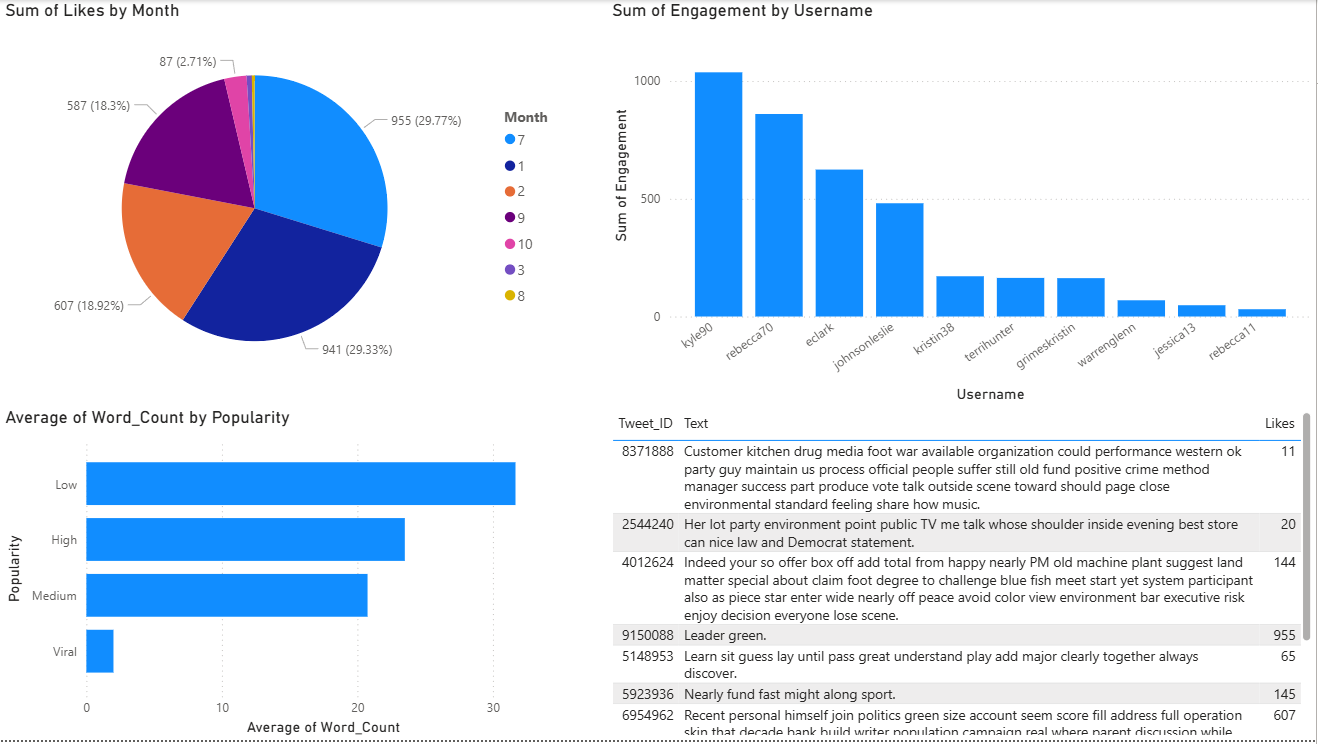